<a href="https://colab.research.google.com/github/mkcyoung/galactic-clustering/blob/main/Gal_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy CNN

The goal of this notebook is to train a model to estimate the probability distribution of galaxy classifications on a large dataset of galaxy images. Following training, we aim to extract the output from one of the layers of the trained network and use it to represent the images so they can be clustered.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Transfering images to folder

#!tar -C '/content/drive/My Drive/Colab Notebooks/data_mining_project/images_training_rev1/' -xvf '/content/drive/My Drive/Colab Notebooks/data_mining_project/images_training_rev1.tgz'

#!unzip '/content/drive/My Drive/Colab Notebooks/data_mining_project/images_training_rev2.zip' -d '/content/drive/My Drive/Colab Notebooks/data_mining_project/'

In [ ]:
# Followed this tutorial: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#
# Also used code this: https://github.com/jimsiak/kaggle-galaxies-pytorch/blob/master/main.py

from __future__ import print_function, division
import os, time, copy, sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms, utils
import torchvision.models as models
from torchvision import datasets

from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
# Changes working directory 
# %cd 'drive/My Drive/Colab Notebooks/data_mining_project'
# %ls


## Setting Parameters

In [ ]:
'''
Global configuration parameters.
'''

### The path where the dataset has been downloaded
#TRAIN_DIR = "/images_training_rev1/"
TRAIN_DIR = "/content/drive/My Drive/Colab Notebooks/data_mining_project/images_training_rev2/"
# TRAIN_DIR = 'images_training_rev2/'

#TRAIN_CSV = "/training_solutions_rev1.csv"
TRAIN_CSV = '/content/drive/My Drive/Colab Notebooks/data_mining_project/training_solutions_rev2.csv'
# TRAIN_CSV = 'training_solutions_rev1.csv'
# TRAIN_CSV = 'training_solutions_rev2.csv'

MODEL = "resnet34" # "sander_dieleman" or "alexnet" or "vgg16" or "resnet50"

SAVE_MODEL = True
MODEL_FILENAME = "model-" + MODEL + ".pt"

OUTPUT_CSV = "output-" + MODEL + ".csv"

NUM_EPOCHS = 8
BATCH_SIZE = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
NR_DEVICES = 1

### For the split in train and validation datasets
RANDOM_SEED = 42
SHUFFLE_DS = True
VALIDATION_SPLIT = 0.2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

'''
Fixed variables.
No need to change anything from here on.
'''

CSV_HEADER = [ "GalaxyID", "Class1.1", "Class1.2", "Class1.3", "Class2.1",
               "Class2.2", "Class3.1", "Class3.2", "Class4.1", "Class4.2",
               "Class5.1", "Class5.2", "Class5.3", "Class5.4", "Class6.1",
               "Class6.2", "Class7.1", "Class7.2", "Class7.3", "Class8.1",
               "Class8.2", "Class8.3", "Class8.4", "Class8.5", "Class8.6",
               "Class8.7", "Class9.1", "Class9.2", "Class9.3", "Class10.1",
               "Class10.2", "Class10.3", "Class11.1", "Class11.2", "Class11.3",
               "Class11.4","Class11.5", "Class11.6"]

cuda:0


## Create dataset

In [ ]:
class GalaxyDataset(Dataset):
    """Galaxy dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.classes_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.classes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        gal_id = self.classes_frame.iloc[idx, 0]
        img_name = self.root_dir + '{}.jpg'.format(gal_id)
        #image = Image.open(img_name)
        image = io.imread(img_name)
        classes = self.classes_frame.iloc[idx, 1:].values
        sample = {'image': image, 'label': classes, 'gal_id':gal_id}

        if self.transform:
            # Convert image from numpy array to PIL image so I can use torchvision transforms
            img_as_img = Image.fromarray(image)
            image = self.transform(img_as_img)
            
            sample = {'image': image, 'label': classes, 'gal_id':gal_id}
            
        return sample

## Iterating through dataset with DataLoader 

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 37])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 37])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 37])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([4, 3, 224, 224]) torch.Size([4, 37])


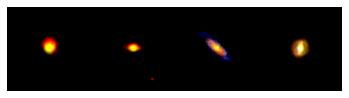

In [ ]:
# Testing dataset with DataLoader

tr_Data = GalaxyDataset(csv_file= TRAIN_CSV,
                                           root_dir=TRAIN_DIR,
                                           transform=transforms.Compose([
                                               transforms.CenterCrop(224),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomRotation(degrees=(0,360)),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
	                                                  std=[0.229, 0.224, 0.225])
                                           ]))


dataloader = DataLoader(tr_Data, batch_size=4,
                        shuffle=True)

# Helper function to show a batch
def show_classes_batch(sample_batched):
    """Show image with classes for a batch of samples."""
    images_batch, classes_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_classes_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Splitting training and validation data

In [ ]:
size = len(tr_Data)
#size = 20000
indices = list(range(size))
split = int(np.floor(VALIDATION_SPLIT * size))
if SHUFFLE_DS:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#print(len(train_indices),len(val_indices))
train_sampler = SubsetRandomSampler(train_indices)
val_sampler   = SubsetRandomSampler(val_indices)

train_dl = DataLoader(tr_Data, batch_size=BATCH_SIZE, num_workers=1,
                                                 sampler=train_sampler)
val_dl = DataLoader(tr_Data, batch_size=BATCH_SIZE, num_workers=1,
                                                 sampler=val_sampler)
print("Total: {} Train_dl: {} Validation_dl: {}".format(size, len(train_dl),
                                                              len(val_dl)))



Total: 18161 Train_dl: 228 Validation_dl: 57


## Functions for training the model

In [ ]:
def train_phase():
    model.train()
    losses = []
    epoch_start = time.time()
    for i, batch in enumerate(train_dl):
        inputs, labels = batch['image'], batch['label'].float().view(-1,37)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()             # 1. Zero the parameter gradients
        outputs = model(inputs)           # 2. Run the model

        loss = criterion(outputs, labels) # 3. Calculate loss
        losses.append(loss.item())
        loss = torch.sqrt(loss)           #    -> RMSE loss
        loss.backward()                   # 4. Backward propagate the loss
        optimizer.step()                  # 5. Optimize the network
        
        #print("--> Batch {}/{} Loss: {}".format(i+1, len(train_dl), loss.item()))
        
    epoch_loss = np.sqrt(sum(losses) / len(losses))
    epoch_time = time.time() - epoch_start
    print("[TST] Epoch: {} Loss: {} Time: {:.0f}:{:.0f}".format(epoch+1, epoch_loss,
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss

def validate_phase():
    model.eval()
    losses = []
    epoch_start = time.time()
    for i, batch in enumerate(val_dl):
        inputs, labels = batch['image'], batch['label'].float().view(-1,37)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)           # 2. Run the model

        loss = criterion(outputs, labels) # 3. Calculate loss
        losses.append(loss.item())
        loss = torch.sqrt(loss)           #    -> RMSE loss
        
        #print("--> Batch {}/{} Loss: {}".format(i+1, len(train_dl), loss.item()))
        
    epoch_loss = np.sqrt(sum(losses) / len(losses))
    epoch_time = time.time() - epoch_start
    print("[VAL] Epoch: {} Loss: {} Time: {:.0f}:{:.0f}".format(epoch+1, epoch_loss,
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss


## Feature extraction helper function

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Initializing and reshaping the network

In [ ]:
# Set to true if doing feature extraction
feature_extract = False

#model = models.vgg13(pretrained=True,progress=True)
model = models.resnet34(pretrained=True,progress=True)

num_classes = 37
# Set requires grad to false if I'm doing feature extraction
set_parameter_requires_grad(model, feature_extract)
# Newly initialized params will be set to true

# VGG or alexnet
#model.classifier[6] = nn.Linear(4096,num_classes)

# Resnet
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 37)

# send model to GPU if available
model.to(device)
# View model
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

## Setting optimizer

In [ ]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# I think MSE loss makes most since b/c this isn't hard categorization
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
#optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999))
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.

## Run the model

In [ ]:
## Training
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_phase()
    val_loss   = validate_phase()
    scheduler.step(val_loss)    
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

[TST] Epoch: 1 Loss: 0.1454570243179699 Time: 122:37
[VAL] Epoch: 1 Loss: 0.15993638406772748 Time: 29:49
[TST] Epoch: 2 Loss: 0.11425516090713983 Time: 1:58
[VAL] Epoch: 2 Loss: 0.11937664606418066 Time: 0:28
[TST] Epoch: 3 Loss: 0.10885555680341633 Time: 2:0
[VAL] Epoch: 3 Loss: 0.12752346338923473 Time: 0:29
[TST] Epoch: 4 Loss: 0.10467005530187569 Time: 2:3
[VAL] Epoch: 4 Loss: 0.1085429318324167 Time: 0:28
[TST] Epoch: 5 Loss: 0.10163262444522674 Time: 2:1
[VAL] Epoch: 5 Loss: 0.10606917108636442 Time: 0:28
[TST] Epoch: 6 Loss: 0.09888330393343607 Time: 1:60
[VAL] Epoch: 6 Loss: 0.12974471173753455 Time: 0:29
[TST] Epoch: 7 Loss: 0.09886707691800437 Time: 2:1
[VAL] Epoch: 7 Loss: 0.11058795386649947 Time: 0:28
[TST] Epoch: 8 Loss: 0.09662258571708404 Time: 2:1
[VAL] Epoch: 8 Loss: 0.10987653083545995 Time: 0:29


## Plotting losses

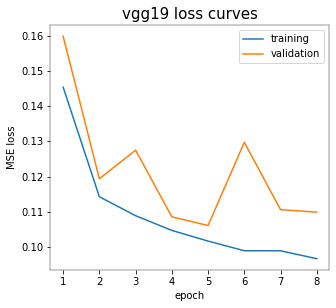

In [ ]:
epochs = range(1,NUM_EPOCHS+1)
plt.figure(figsize = (5,4.5))
plt.plot(epochs,train_losses,label='training')
plt.plot(epochs,val_losses,label='validation')
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title('vgg19 loss curves',fontsize=15)
plt.legend()
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]


plt.show()

## Saving Model

In [ ]:
if SAVE_MODEL:
	torch.save(model, MODEL_FILENAME)
    

# Loading saved model

In [ ]:
## Load saved model

PATH = '/model-resnet34.pt'
# Model class must be defined somewhere
model = torch.load(PATH)#,map_location=torch.device('gpu'))

# Maybe comment out eval and run again? IDK 
model = model.eval()

## Feature extraction using trained model

In [ ]:
# For VGG
#print(*list(model.classifier.children())[:-2]) # This has been best so far

# For resnet
#print(*list(model.children())[:-1])

# remove last fully-connected layer

# For VGG or alexnet
# new_classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# model.classifier = new_classifier

# For resnet
model = torch.nn.Sequential(*list(model.children())[:-1])
                        #torch.nn.ReLU(inplace=True))
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Let's loop through some images and extract feature vectors
# of galaxy data

num_galaxies = 500
# For VGG
#shaper = 4096
# For resnet
shaper = 512

feat_vec = []
my_labels = []
gal_id = []
for i,samples in enumerate(tr_Data):
    #print(samples['image'])
    feat_vec.append(model(samples['image'].cuda().unsqueeze_(0)).cpu().detach().numpy().reshape(shaper))
    my_labels.append(list(samples['label']))
    gal_id.append(samples['gal_id'])
    # if i ==num_galaxies:
    #     break


In [ ]:
# Make label categories
#print(my_labels)
# Need to categorize these by looping through labels, extracting argmax
# This is a somewhat arbitrary extraction, could go into more detail later if interested
gal_classes = ['round:completely round','round:in-between','round:cigar-shaped', \
              'disk:rounded','disk:boxy','disk:no bulge', \
              'spiral','no spiral']
colorby =[]
for i in my_labels:
    #i = i[0]
    gal_type = np.argmax(i[0:3])
    if gal_type == 0:
        round_type = np.argmax(i[15:18])
        if round_type == 0:
            # completely round
            colorby.append(0)
        elif round_type == 1:
            # in between
            colorby.append(1)
        else:
            # cigar shaped
            colorby.append(2)
    else:
        disk_type = np.argmax(i[3:5])
        if disk_type == 0:
            # Bulge
                bulge_type = np.argmax(i[25:28])
                if bulge_type == 0:
                    # rounded
                    colorby.append(3)
                elif bulge_type == 1:
                    # boxy
                    colorby.append(4)
                elif bulge_type == 2:
                    # no bulge
                    colorby.append(5)
        elif disk_type == 1:
            # spiral?
            spiral_type = np.argmax(i[7:9])
            if spiral_type == 0:
                # spiral
                colorby.append(6)
            elif spiral_type == 1:
                # No spiral
                colorby.append(7)
                    
    

print(len(colorby))

501


501
501
501


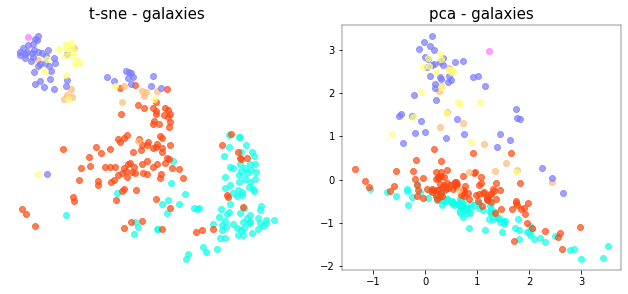

In [ ]:
# Let's do t-SNE and PCA to see if anything interesting happens

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X = feat_vec

pca_coordsG = pca.fit_transform(X)

tsne_coordsG = TSNE(n_components=2,perplexity=30,learning_rate=100).fit_transform(X)

colorsG = ['#11ffeb','#ff4911','#ffbd7a', '#7a7aff', '#fd7aff', '#ffff7a']

Y = np.array(colorby)
print(len(Y))
print(len(pca_coordsG))
print(len(tsne_coordsG))

plt.figure(figsize = (11,4.5))
plt.subplot(1,2,1)
for c, i, lab in zip(colorsG, [0, 1, 2, 3, 4, 5, 6, 7], gal_classes):
    plt.scatter(tsne_coordsG[Y==int(i),0], tsne_coordsG[Y==int(i),1], alpha=0.7, c=c, label=lab)
#plt.legend()
plt.title('t-sne - galaxies',fontsize=15)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.subplot(1,2,2)
for c, i, lab in zip(colorsG, [0, 1, 2, 3, 4, 5, 6, 7], gal_classes):
    plt.scatter(pca_coordsG[Y==int(i),0], pca_coordsG[Y==int(i),1], alpha=0.7, c=c, label=lab)
#plt.legend()
plt.title('pca - galaxies',fontsize=15)
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.show()

In [ ]:
#print(X)
print(Y)

# Saving CSVs

In [ ]:
print(len(feat_vec))
print(len(my_labels))
print(len(colorby))

X = np.array(feat_vec)
print(X.shape)

# Saves feature vector data
df = pd.DataFrame(data=X)
df.to_csv("./X.csv", sep=',',index=False)

# Saves label data
df = pd.DataFrame(data=my_labels)
df.to_csv("./Y.csv", sep=',',index=False)

# Saves color by data
df = pd.DataFrame(data=colorby)
df.to_csv("./colorby.csv", sep=',',index=False)

# Saves gal id data
df = pd.DataFrame(data=colorby)
df.to_csv("./gal_id.csv", sep=',',index=False)
